In [15]:
import arrow as A
import scipy
from PIL import Image
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import itertools
import torchvision
import xarray as xr

In [3]:
torch.cuda.empty_cache()
print(f'( {torch.cuda.device_count()} ) {torch.cuda.get_device_name(0)} available')

( 1 ) NVIDIA GeForce GTX 1080 Ti available


In [25]:
class Lnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # in layer
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1, bias=False)
        self.relu1 = torch.nn.ReLU(inplace=True)
        # hidden layers
        hidden_layers = []
        for i in range(20):
            hidden_layers.append(torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
            hidden_layers.append(torch.nn.BatchNorm2d(64))
            hidden_layers.append(torch.nn.ReLU(inplace=True))
        self.mid_layer = torch.nn.Sequential(*hidden_layers)
        # out layer
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out1 = self.relu1(self.conv1(x))
        out = self.mid_layer(out1)
        out = self.conv3(out+out1)
        return out
    
class dset_maker(torch.utils.data.Dataset):
    def __init__(self,x,y):
        self.x = torch.load(x)
#         print(self.x.shape)
        self.y = torch.load(y)
    
        rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],100))
        
        self.x = self.x[rand_pts]
        self.y = self.y[rand_pts]
        
        self.combo = torch.cat((self.x.unsqueeze(0),self.y.unsqueeze(0)),0)
        
        RVF = torchvision.transforms.RandomVerticalFlip()
        RHF = torchvision.transforms.RandomHorizontalFlip()
        
        self.combo_transformed = RVF(RHF(self.combo))
        self.x = self.combo_transformed[0]
        self.y = self.combo_transformed[1]
        
        
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)

        return x, y
    def __len__(self):
#         print(self.x.shape[0])
        return self.x.shape[0]

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data,1.0,0.02)
        torch.nn.init.constant_(m.bias.data,0)  

In [26]:
dset = dset_maker('../../sst_old/data/amsgan_196x196.pt',
                  '../../sst_old/data/modgan_196x196.pt')

lr = 1e-5
train_size = int(0.80*len(dset))
valid_size = int(0.5*(len(dset) - train_size))
test_size = int(len(dset)-train_size-valid_size)
train_dset, valid_dset, test_dset = torch.utils.data.random_split(dset,[train_size,valid_size,test_size])


train_dataloader = torch.utils.data.DataLoader(dataset=train_dset, batch_size=2, shuffle=True, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dset, batch_size=1, shuffle=True, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Lnet().to(device)
model.apply(weights_init)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

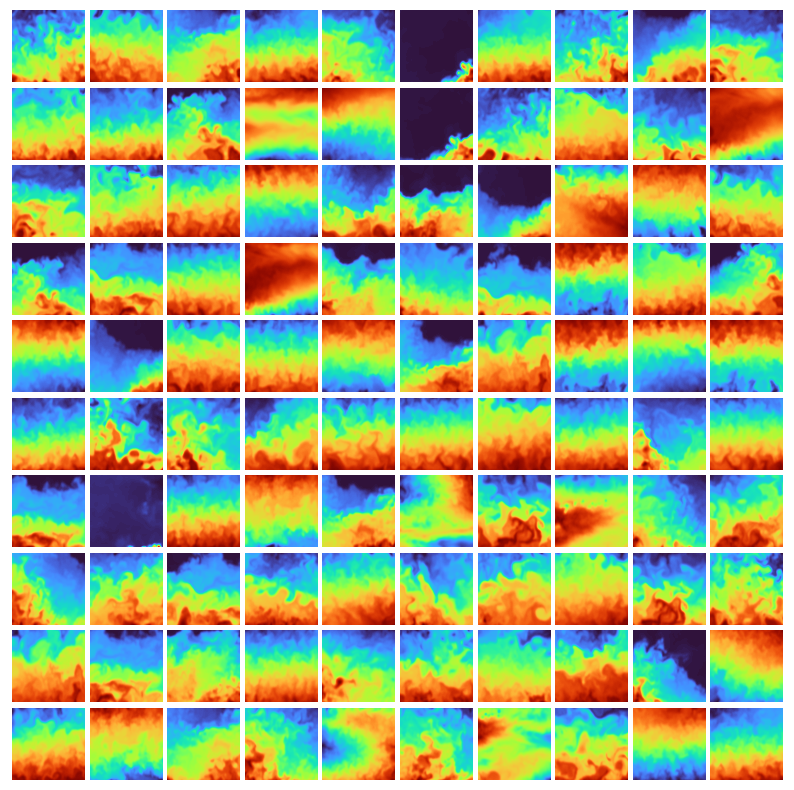

In [27]:
hei=10
wid=10

fig = plt.figure(figsize=(10,10))
# plt.title(f'{date}_{satnames[idx]}_{oc}_{satt}')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])
    plt.imshow(dset.x[idy,0],cmap='turbo')
    plt.axis('off')

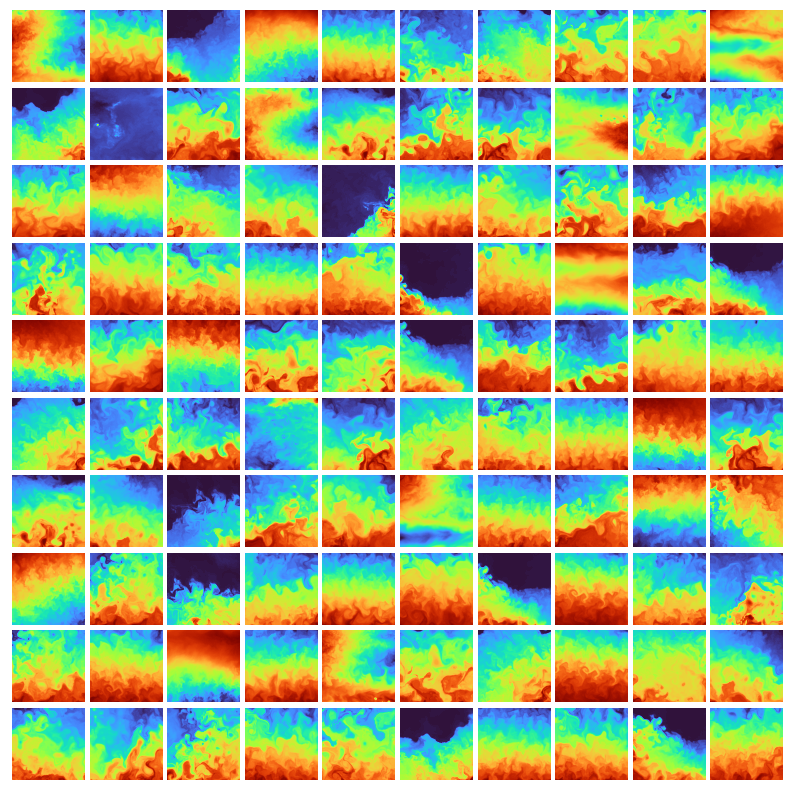

In [10]:
hei=10
wid=10

fig = plt.figure(figsize=(10,10))
# plt.title(f'{date}_{satnames[idx]}_{oc}_{satt}')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])
    plt.imshow(dset.y[idy,0],cmap='turbo')
    plt.axis('off')

In [28]:
t0 = A.now('US/Eastern')

def train(epoch):
    epoch_loss = 0
    c=0
    for x,y in train_dataloader:
        c+=1

        # target = y-x
        predicted = model(x)

        loss = criterion(predicted, y)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    print(f'Epoch {epoch} Train Mean MSE: {epoch_loss/len(train_dataloader)}')
    
def validate():
    # validate.avg_psnr = 0
    # avg_psnr = 0
    model.eval()
    with torch.no_grad():
        t_loss = 0
        for xx,yy in valid_dataloader:
            # target = yy-xx
            predicted = model(xx)
            mse = criterion(predicted, yy)
            t_loss += mse.item()
            # modis = yy.cpu().numpy().squeeze().squeeze();
            # amsre = xx.cpu().numpy().squeeze();
            # adj = predicted.cpu().numpy().squeeze();
            # # psnr = 10 * np.log10(np.power(np.max(modis),2) / mean_squared_error(modis,amsre+adj))
            # validate.avg_psnr += (psnr / len(valid_dataloader))
        
    print(f"\t\t\t\t\t\tEpoch {epoch} Valid Mean MSE: {t_loss/len(valid_dataloader)}")
    

    
# def save_checkpoint(state):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(state, model_out_path)
#     print(f"Checkpoint saved to {model_out_path}")
    
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    if epoch == 1:
        validate()
    train(epoch)
    if epoch % 2 == 0:
        validate()
t1 = A.now('US/Eastern')

						Epoch 1 Valid Mean MSE: 99.13876688480377
Epoch 1 Train Mean MSE: 176.84449952840805
Epoch 2 Train Mean MSE: 173.90870188176632
						Epoch 2 Valid Mean MSE: 95.94305572509765
Epoch 3 Train Mean MSE: 171.15532302856445
Epoch 4 Train Mean MSE: 168.04220577180385
						Epoch 4 Valid Mean MSE: 92.09200973510742
Epoch 5 Train Mean MSE: 149.60115730762482
Epoch 6 Train Mean MSE: 13.166078780591487
						Epoch 6 Valid Mean MSE: 4.310726773738861
Epoch 7 Train Mean MSE: 5.342781940102578
Epoch 8 Train Mean MSE: 4.901527878642082
						Epoch 8 Valid Mean MSE: 3.2196156442165376
Epoch 9 Train Mean MSE: 4.718475991487503
Epoch 10 Train Mean MSE: 4.5499320581555365
						Epoch 10 Valid Mean MSE: 2.9668405055999756
Epoch 11 Train Mean MSE: 4.359243941307068
Epoch 12 Train Mean MSE: 4.182509168982506
						Epoch 12 Valid Mean MSE: 2.7232903748750688
Epoch 13 Train Mean MSE: 4.019145300984382
Epoch 14 Train Mean MSE: 3.8448543950915335
						Epoch 14 Valid Mean MSE: 2.4954930901527406
Epoch 15

In [16]:
a = xr.open_dataset('../data/LLC4320_2011-11-20T00_00_00.nc')
a = np.asarray(a.Theta)
a = Image.fromarray(a)
a = a.resize((a.width*2,a.height*2))
a = np.asarray(a)
foot = np.asarray(scipy.io.loadmat('../data/mean_along_scan_footprint.mat')['footAverage'])
foot = Image.fromarray(foot)
foot = foot.resize((foot.width*4,foot.height*4))
foot = np.asarray(foot)/16
a = torch.from_numpy(a).unsqueeze(0).unsqueeze(0).float()
foot = torch.from_numpy(foot).unsqueeze(0).unsqueeze(0).float()
m_foot = torch.from_numpy(np.ones((10,10))/100).unsqueeze(0).unsqueeze(0).float()
amsre = torch.nn.functional.conv2d(a,foot,stride=10)
modis = torch.nn.functional.conv2d(a,m_foot,stride=10)

In [17]:
amsre_patch = amsre[0,0,1300:1496,1000:1196]
modis_patch = modis[0,0,1300:1496,1000:1196]

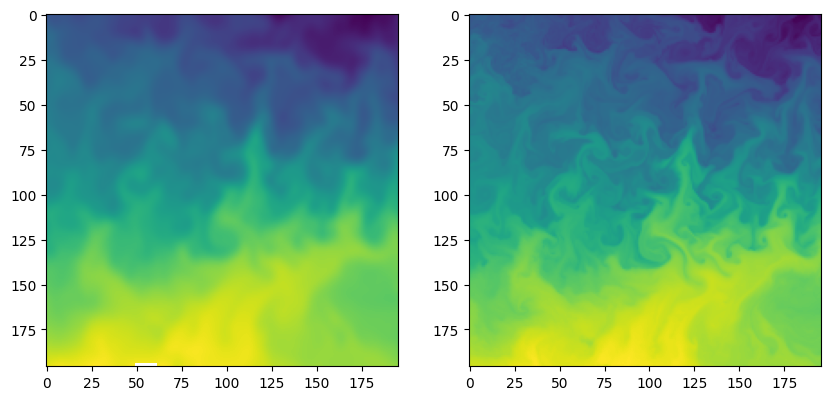

In [153]:

fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1,2)


fig.add_subplot(gs[0,0])
plt.imshow(amsre_patch)

fig.add_subplot(gs[0,1])
plt.imshow(modis_patch)

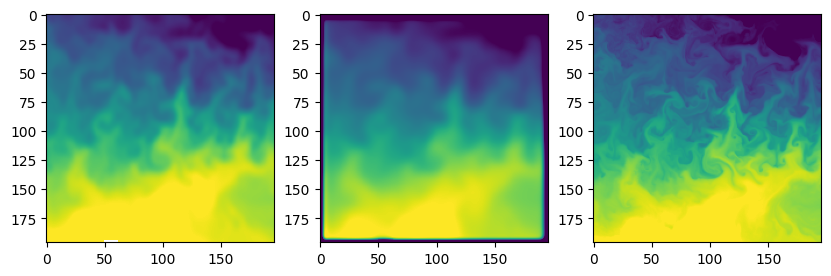

In [29]:
class small_dset_creator(torch.utils.data.Dataset):
    def __init__(self,x,y):
        self.x = x.unsqueeze(0).unsqueeze(0)
        self.y = y.unsqueeze(0).unsqueeze(0)
        self.z = self.y - self.x
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
        y = self.y[idx].to('cuda')
        return x,y
    def __len__(self):
        return self.x.shape[0]
    
ds = small_dset_creator(amsre_patch, modis_patch)
dl = torch.utils.data.DataLoader(ds,shuffle=False)

model.eval()
pred = []
with torch.no_grad():
    for x,y in dl:
        # target = y-x
        predicted = model(x)
        pred.append(predicted)
        # mse = criterion(predicted,target)
        # test_loss += item()
            
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1,3)


fig.add_subplot(gs[0,0])
plt.imshow(amsre_patch,vmin=22,vmax=28)
# plt.colorbar(fraction=.02)

fig.add_subplot(gs[0,1])
plt.imshow(pred[0].cpu()[0,0],vmin=22,vmax=28)

fig.add_subplot(gs[0,2])
plt.imshow(modis_patch,vmin=22,vmax=28)



In [186]:
pred[0].shape

torch.Size([1, 1, 196, 196])

In [101]:
infer.amsre.shape

torch.Size([1, 1, 2580, 3447])

In [74]:
import xarray as xr
llc = xr.open_dataset('../data/LLC4320_2011-11-20T00_00_00.nc')
llc

<xarray.Dataset>
Dimensions:  (i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_l: 1)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Dimensions without coordinates: k_l
Data variables:
    Theta    (j, i) float32 ...
    U        (j, i_g) float32 ...
    V        (j_g, i) float32 ...
    W        (k_l, j, i) float32 ...
    Salt     (j, i) float32 ...

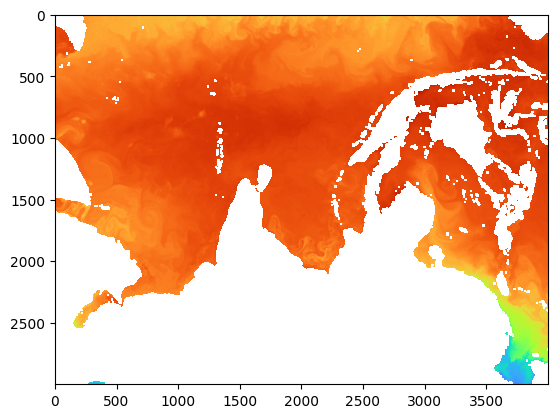

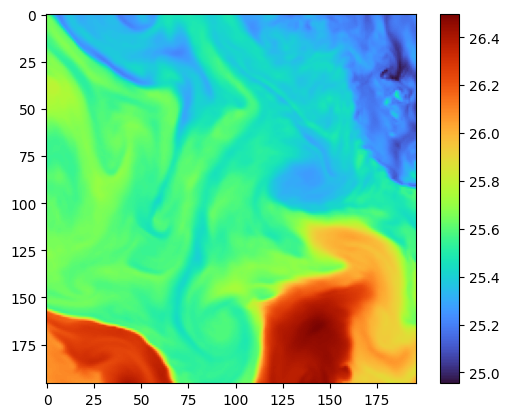

In [88]:
xup = 7000
xdown = xup+196
yleft = 4500
yright = yleft+196

plt.figure()
plt.imshow(llc.Theta[7000:10000,4000:8000],cmap='turbo')

plt.figure()
plt.imshow(llc.Theta[xup:xdown,yleft:yright],cmap='turbo')
plt.colorbar()